## Tutorial: Tokenization and Transformer Model

#### Objective
- Understand tokenization and how it prepares text data for transformers.
- Explore how transformers process tokenized input using attention mechanisms and visualize attention weights to observe how transformers focus on specific tokens.
- Examine the inference process in GPT models, highlighting techniques that optimize performance.

#### Prerequisites
- Python installed (3.8+ recommended).
- Install necessary libraries:

In [1]:
pip install transformers torch matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


#### Step 1: Tokenization Basics

Tokenization is the process of breaking down text into smaller units (tokens) that a model can understand. Subword tokenization (e.g., Byte-Pair Encoding) is commonly used in transformers.

**Pre-trained Tokenizer **

In [2]:
from transformers import AutoTokenizer

# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Sample text
text = "Transformers have revolutionized natural language processing!"

# Tokenize the input
tokens = tokenizer.tokenize(text)
input_ids = tokenizer(text, return_tensors="pt")["input_ids"]

print("Original Text:", text)
print("Tokens:", tokens)
print("Input IDs:", input_ids)

Original Text: Transformers have revolutionized natural language processing!
Tokens: ['transformers', 'have', 'revolution', '##ized', 'natural', 'language', 'processing', '!']
Input IDs: tensor([[  101, 19081,  2031,  4329,  3550,  3019,  2653,  6364,   999,   102]])


** Trained tokenizer**

In [ ]:
from tokenizers import Tokenizer, models, trainers

# Initialize a new BPE tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# Train the tokenizer on custom data
trainer = trainers.BpeTrainer(vocab_size=50_000)
tokenizer.train_from_iterator(["Hello, how are you?", "I am fine, thank you!"], trainer)

# Example usage
input_text = "Hello, how are you?"
tokens = tokenizer.encode(input_text)
print(tokens.tokens())  # Outputs tokens based on trained vocabulary


#### Step 2: Understanding Transformers
**Transformer Architecture**

Transformers process tokenized inputs through layers of self-attention and feed-forward networks, generating contextualized embeddings for each token.

In [4]:
from transformers import AutoModel

# Load a pre-trained transformer model
model = AutoModel.from_pretrained("bert-base-uncased")

# Pass the tokenized input to the model
outputs = model(input_ids)

# Extract the hidden states
hidden_states = outputs.last_hidden_state

print("Shape of Hidden States:", hidden_states.shape)


Shape of Hidden States: torch.Size([1, 10, 768])


** Explanation: **
- `hidden_states` contains contextual embeddings for each token.
- The shape is `[batch_size, sequence_length, hidden_size]`.

#### Step 3: Visualizing Attention Weights
**What Are Attention Weights?**

Attention weights determine how much importance the model assigns to each token when processing a given token.

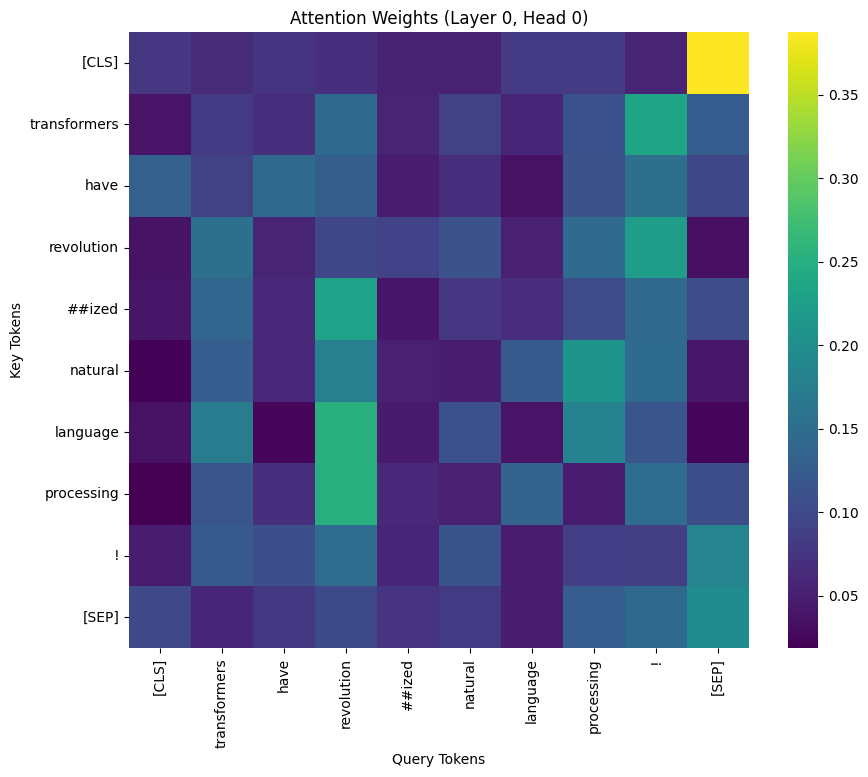

In [5]:
from transformers import BertModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load the model with attention outputs enabled
model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

# Forward pass to extract attention weights
outputs = model(input_ids)
attention_weights = outputs.attentions  # List of attention matrices (one per layer)

# Select attention weights from the first layer and the first head
layer = 0  # First layer
head = 0   # First attention head
attention_matrix = attention_weights[layer][0, head].detach().numpy()

# Visualize the attention matrix
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title("Attention Weights (Layer 0, Head 0)")
plt.xlabel("Query Tokens")
plt.ylabel("Key Tokens")
plt.show()


#### Step 4: Decoding Model Inference:

- Inference with classic auto-regressive decoding (slow)
- Inference with speculative decoding (faster)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sampling import speculative_generate, autoregressive_generate
from utils.logits_processors import NucleusProcessor

# Load the target (large) and drafter (small) models
target_model_name = "Gemma2-2B"  # Replace with actual model name
drafter_model_name = "Gemma2-250M"  # Smaller drafter model

tokenizer = AutoTokenizer.from_pretrained(target_model_name)
target_model = AutoModelForCausalLM.from_pretrained(target_model_name)
drafter_model = AutoModelForCausalLM.from_pretrained(drafter_model_name)

# Define parameters for generation
gen_len = 100  # Maximum number of tokens to generate
gamma = 4  # Number of drafts generated by the drafter model at each step
logits_processor = NucleusProcessor(temperature=0.6, top_p=0.9)

# Input prompt for generation
input_text = "Once upon a time"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Generate text using classic auto-regressive decoding (slow)
output_ids_ar = autoregressive_generate(
    input_ids,
    target_model,
    logits_processor=logits_processor,
    max_gen_len=gen_len,
    end_tokens_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

output_ar = tokenizer.decode(output_ids_ar[0], skip_special_tokens=True)

# Generate text using speculative decoding (faster)
output_ids_sd, alpha = speculative_generate(
    input_ids,
    drafter_model,
    target_model,
    logits_processor=logits_processor,
    gamma=gamma,
    max_gen_len=gen_len,
    end_tokens_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

output_sd = tokenizer.decode(output_ids_sd[0], skip_special_tokens=True)

print("Auto-regressive decoding:", output_ar)
print("Speculative decoding:", output_sd)
